# Projektna naloga pri predmetu Statistične metode v edukaciji

## Matematična anksioznost in motivacija

### Ljubljana, maj 2024

#### Avtor: Bor Bregant [98233001]

#### Mentorica: doc. dr. Ana Slavec

---

### Struktura projektne naloge:

Sama statistika je v blokih kode s komentarji za znakom #.

Vse prikazane tabele imajo prvi stolpec indeksni (torej 0, 1, ...), zaradi narave programa in ne predstavlja dodane vrednosti.

Za vse interferenčne statistike bomo vzeli stopnjo zaupanja $\alpha = 0.05$.


<link rel="stylesheet" type="text/css" href="STATISTIKA.css">

In [61]:
#=============================
#Tu bomo uvozili vse potrebne pakete (knjižnice)
#=============================
import numpy as np                              #Za obdelavo datasetov in elementarno računanje
import pandas as pd                             #Za obdelavo
from sklearn.preprocessing import LabelEncoder  #Za kodiranje kategoričnih spremenljivk
import pingouin as pg                           #Za statistiko (\alpha)
from matplotlib import pyplot                   #Za vizualizacijo
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import seed                   #Za "ponavljivost" metod, ki morebitno uporabljajo šum
from scipy.stats import pearsonr                #Scipy.stats je paket za statistične funkcije
from scipy.stats import shapiro, probplot
from scipy import stats
import statsmodels.formula.api as smf           #Linearna regresija
from sklearn.linear_model import LinearRegression
from scipy.stats import skew, kurtosis          #Skew in Kurtosis

seed(42) #Nastavimo seme za ponavljivost

### Uvoz podatkov

Na tem mestu bomo uvozili ne-anomiziran nabor podatkov.

Vzorec sestavlja 89 dijakov drugega in tretjega letnika izbrane slovenske gimnazije v šolskem letu 2023/24. Vzeti so iz populacije gimnazijcev (prvega in četrtega letnika nismo vzeli zaradi (i) zgodnjega časovnega okvirja [september], kar bi lahko motilo 1. letnike in (ii) zaradi priprav na maturo).

V raziskavi smo aplicirali kavzalno ne-eksperimentalno metodo. Na podlagi uveljavljenih instrumentov (test AMAS za anksioznost in AtMI za motivacijo) smo sestavili vprašalnik in ga razdelili s pomočjo orodja Google forms. Vzorec je bil neslučajnostni in namenski.


[Vprašalnik se nahaja tukaj.](https://github.com/borbregant/Doktorat/blob/main/Vpra%C5%A1alnik.pdf)

In [62]:
df = pd.read_csv("motivacija.csv") #Preberemo datoteko

#Izpustimo stolpce, ki niso relevantni
df.drop("Časovni žig", axis=1, inplace=True)
df.drop("Uporabniško ime", axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

#=============================
#Tu bomo pred vpogledom najprej podatke anonimizirali s pomočjo "label" oz. kategoričnega kodiranja.
#=============================
le = LabelEncoder()
 
label = le.fit_transform(df['Razred'])          #Transformiramo stolpec, ki se nanaša na razred, slednjega izbrišemo in nadomestimo s kodiranim (s tem dobimo anonimnost)
df.drop("Razred", axis=1, inplace=True)
df["Razred"] = label

label = le.fit_transform(df['Učeči profesor'])  #Enako za profesorja, ki razred uči
df.drop("Učeči profesor", axis=1, inplace=True)
df["Profesor"] = label

label = le.fit_transform(df['Spol'])            #In za spol (čeprav ni potrebno anonimiziranja)
df.drop("Spol", axis=1, inplace=True)
df["Spol"] = label

df = df.apply(pd.to_numeric)                    #Zdaj, ko nam je struktura všeč, vse spremenljivke (tudi kategorične npr. spol) nadomestimo z numerično vrednostjo

df.head()                                       #In pogledamo, kaj smo dobili :)

,V moji izobraževalni poti želim imeti čim več matematike,Na fakulteti bi se rad izognil matematiki,Težavnost matematike me privlači,Učenje (napredne) matematike smatram za uporabno,Deljenje idej za reševanje matematičnega problema mi je v coni udobja,Rad imam matematiko,Matematika je dolgočasna,Uporaba in iskanje formul ter tabel na zadnji strani poglavja v učbeniku,Razmišljanje o testu matematike dan prej,"Gledanje profesorja, ki na tablo rešuje enačbo",Test matematike,Domače naloge pri matematiki,Poslušanje ure matematike v razredu,"Poslušanje sošolca, ki razlaga snov pri matematiki",Pisanje kratkega nenapovedanega preverjanja pri matematiki,Začetek nove snovi pri pouku matematike,Razred,Profesor,Spol
0,4,1,3,3,4,5,2,1,1,1,2,3,1,1,5,1,5,1,0
1,4,1,1,4,3,4,2,2,4,2,5,2,3,1,5,2,5,1,1
2,3,2,4,3,2,4,3,1,2,1,3,1,2,2,4,1,3,1,0
3,3,4,1,3,2,3,3,3,5,2,5,4,4,3,5,4,5,1,1
4,3,3,3,2,3,4,1,4,4,4,4,4,5,4,2,3,3,1,1


In [63]:
print("Število vrstic:", len(df))           #Koliko je velik naš vzorec
print("Število stolpcev:", len(df.columns)) #Kako dolg imamo vprašalnik
print(df['Razred'].nunique())               #Koliko imamo različnih stratumov (možnih vrednosti) za razed
print(df['Profesor'].nunique())             #Enako za učeče profesorje

Število vrstic: 89
Število stolpcev: 19
6
3


Imamo 89 rešenih odgovorov za vprašalnik, ki ga je sestavljalo 19 vprašanj.

Prvih sedem stolpcev sestavlja spremenljivko "Motivacija". Dve vprašanji sta inverzno točkovani, vsa pa na Likertovi lestvici od 1 do 5. Spremenljivke so torej ordinalne, ki jih bomo združili v eno diskretno (ki se obnaša zvezno - razmernostno). Vprašanja so izveta iz uveljavljenega instrumenta ATMI (Attitudes towards mathematics instruction)

Naslednjih devet vprašanj sestavlja matematično anksioznost. Prav tako ordinalne spremenljivke, ki jih bomo združili v eno diskretno.

Sledijo še 3 nominalne spremenljivke. (i) Razred, ki ima 6 kategorij, (ii) Profesor, ki ima 3 kategorije, in (iii) Spol, kjer 0 predstavlja Moške, 1 pa Ženske.

## Kalkulacija kronbach alpha (Faktorska analiza)

Na tem mestu bomo vprašanja, ki določajo eno spremenljivko združili in določili notranjo konsistenco vprašalnikov

In [64]:
included_columns = ['V moji izobraževalni poti želim imeti čim več matematike', 'Na fakulteti bi se rad izognil matematiki', 'Težavnost matematike me privlači', 'Učenje (napredne) matematike smatram za uporabno', 'Deljenje idej za reševanje matematičnega problema mi je v coni udobja',"Rad imam matematiko","Matematika je dolgočasna"]  # Vključimo stolpce, ki določajo motivacijo

# Reverzno točkovani odgovori (želimo torej 2 <-> 4 in 1 <-> 5)
reverse_score_columns = ['Na fakulteti bi se rad izognil matematiki', 'Matematika je dolgočasna']

# Funkcija za reverzno točkovanje
def reverse_score(x):
    return max(x) + min(x) - x

# To funkcijo uporabimo na željenih vprašanjih
for col in reverse_score_columns:
    df[col] = reverse_score(df[col])

# Izračun notranje konsistence
alpha, ci = pg.cronbach_alpha(df[included_columns], ci=0.95)
print("Cronbachov Alpha:", alpha)
print("Interval zaupanja (95%):", ci)

Cronbachov Alpha: 0.9175220227495999
Interval zaupanja (95%): [0.888 0.941]


In [65]:
#Enako za anksioznost
included_columns = ['Uporaba in iskanje formul ter tabel na zadnji strani poglavja v učbeniku','Razmišljanje o testu matematike dan prej','Gledanje profesorja, ki na tablo rešuje enačbo',"Domače naloge pri matematiki","Poslušanje ure matematike v razredu","Poslušanje sošolca, ki razlaga snov pri matematiki","Pisanje kratkega nenapovedanega preverjanja pri matematiki","Začetek nove snovi pri pouku matematike"]

alpha, ci = pg.cronbach_alpha(df[included_columns], ci=0.95)
print("Cronbachov Alpha:", alpha)
print("Interval zaupanja (95%):", ci)

Cronbachov Alpha: 0.8375165268656393
Interval zaupanja (95%): [0.781 0.884]


Vprašalnik za matematično anksioznost je odličen glede notr. konsistentnosti (angl. reliability), za mat. motivacijo pa dober.

### Ti dve spremenljivki bomo zdaj izračunali iz več vprašanj (enostavna faktorska analiza)

In [66]:
#Izračunamo (po funkciji reverse_score, če je potrebno) in izbrišemo stolpce, ki niso več potrebni
df['Motivacija'] = df['V moji izobraževalni poti želim imeti čim več matematike'] +6-df['Na fakulteti bi se rad izognil matematiki'] + df['Težavnost matematike me privlači'] + df['Učenje (napredne) matematike smatram za uporabno'] + df["Deljenje idej za reševanje matematičnega problema mi je v coni udobja"] +df["Rad imam matematiko"] +6-df["Matematika je dolgočasna"]

df.drop(['V moji izobraževalni poti želim imeti čim več matematike', 'Na fakulteti bi se rad izognil matematiki', 'Težavnost matematike me privlači', 'Učenje (napredne) matematike smatram za uporabno', "Deljenje idej za reševanje matematičnega problema mi je v coni udobja", "Rad imam matematiko", "Matematika je dolgočasna"], axis=1, inplace=True)

In [67]:
df['Anksioznost'] = df['Uporaba in iskanje formul ter tabel na zadnji strani poglavja v učbeniku'] + df['Razmišljanje o testu matematike dan prej'] + df['Gledanje profesorja, ki na tablo rešuje enačbo'] + df['Test matematike'] + df["Domače naloge pri matematiki"] +df["Poslušanje ure matematike v razredu"] + df["Poslušanje sošolca, ki razlaga snov pri matematiki"] + df["Pisanje kratkega nenapovedanega preverjanja pri matematiki"] + df["Začetek nove snovi pri pouku matematike"]


df.drop(['Uporaba in iskanje formul ter tabel na zadnji strani poglavja v učbeniku', 'Razmišljanje o testu matematike dan prej', 'Gledanje profesorja, ki na tablo rešuje enačbo', 'Test matematike', "Domače naloge pri matematiki", "Poslušanje ure matematike v razredu", "Poslušanje sošolca, ki razlaga snov pri matematiki", "Pisanje kratkega nenapovedanega preverjanja pri matematiki", "Začetek nove snovi pri pouku matematike"], axis=1, inplace=True)

In [68]:
#Če bi želeli, bi lako prečiščeno datoteko še shranili
#df.to_excel("data_cleaned_NE_SHRANI.xlsx")
df.head()

,Razred,Profesor,Spol,Motivacija,Anksioznost
0,5,1,0,22,16
1,5,1,1,19,26
2,3,1,0,21,17
3,5,1,1,19,35
4,3,1,1,19,34


Dobili smo tabelo pripravljeno za statistično obdelavo. Razred, spol in učeči profesor so kodirane z label encodingom (v tem programskem jeziku se s tem izognemo nevšečnostim, hkrati pa zagotovimo anonimizacijo). Prvi stolpec je indeksni (v članku bi ga npr. izpustili, tukaj ga program ne zna izpustiti).

Sledijo 3 nominalne spremenljivke. (i) Razred, ki ima 6 kategorij, (ii) Profesor, ki ima 3 kategorije, in (iii) Spol, kjer 0 predstavlja Moške, 1 pa Ženske.

Zadnja dva stolpca sta za naše analize najpomembnejša in predstavljata mat. anks. in motivac.

In [69]:
#Če bi želeli, bi lahko podatke še skalirali. S tem bi sicer izgubili možnost primerjave z drugimi raziskavami, ki uporabljajo enake instrumente, toda marsikaj tudi pridobimo.

#from sklearn.preprocessing import MinMaxScaler
#scaler = StandardScaler()

#df[['Motivacija', 'Anksioznost']] = scaler.fit_transform(df[['Motivacija', 'Anksioznost']])

### Vizualizacija podatkov in deskriptivna analiza

In [70]:
#Najprej si oglejmo osnovne statistične pojme povprečja, stand. odklona, min., max., in informacije o kvantilih

selected_columns = ['Motivacija', 'Anksioznost'] #Izberemo smiselni spremenljivki za to analizo

print(df[selected_columns].describe().round(2)) # Opišemo in zaokrožimo

       Motivacija  Anksioznost
count       89.00        89.00
mean        20.10        26.48
std          4.04         8.35
min          8.00         9.00
25%         17.00        20.00
50%         20.00        27.00
75%         23.00        32.00
max         31.00        44.00


To tabelo bomo komentirali v poglavju Interferenčne statistike, saj bomo podatke še bolj karakterizirali.

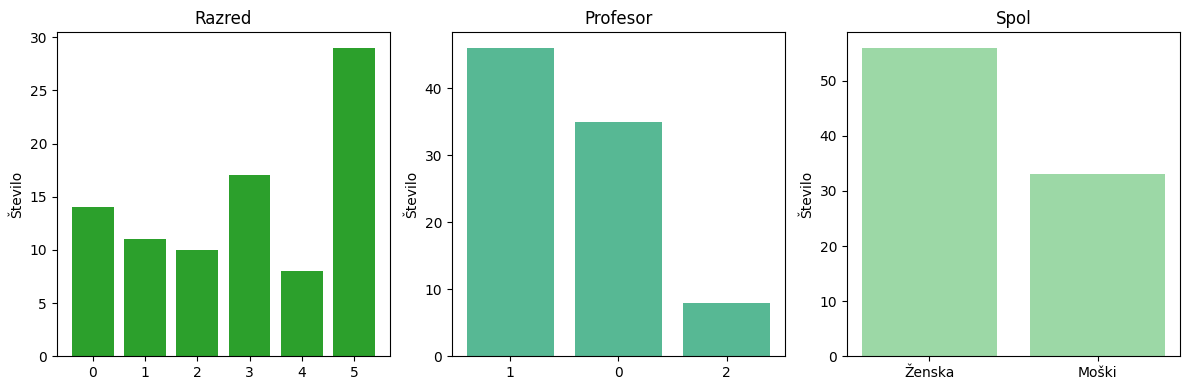

In [71]:
# Izberemo kategorične spremenljivke
categories = ['Razred', 'Profesor', 'Spol']
green = ['#2ca02c', '#57b894', '#9cd8a6']       # Vse bomo označili z enako barvo
fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # Določimo same parametre grafa

# Izračunamo deleže in narišemo grafe
for i, category in enumerate(categories):
    values = df[category].value_counts()
    percentages = (values / values.sum()) * 100
    
    # Kategorije spola seveda poznamo
    if category == 'Spol':
        values.index = values.index.map({0: 'Moški', 1: 'Ženska'}.get)
    
    # Dodelimo barvo
    colors = [green[i] for _ in range(len(values))]

    if category == 'Profesor':
        x = np.arange(len(values))              # ustvari seznam vrednosti od 0 do len(values) - 1 (brez tega naprej je čudno dojel skalo na x osi)
        axs[i].bar(x, values, color=colors)
        axs[i].set_xticks(x)                    # Postavi označbe na x
        axs[i].set_xticklabels(values.index)    # Postavi oznake na x glede na indeks vrednosti
    else:
        axs[i].bar(values.index, values, color=colors)
    
    axs[i].set_title(category)
    axs[i].set_ylabel('Število')                  # Dodamo oznako za y os

plt.tight_layout()
plt.show()


Zgornje podatek o kvantilih lahko tudi vizualiziramo. Namesto škatle z brki uporabimo violinsko alternativo, ki vključi tudi samo porazdelitev

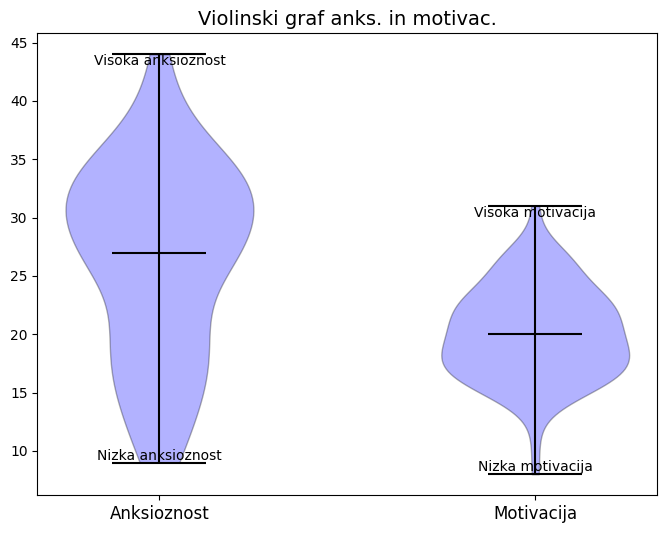

In [72]:
fig, ax = plt.subplots(figsize=(8, 6))  # Specificiramo parametre grafa
data_to_plot = [df["Anksioznost"], df["Motivacija"]]
positions = [1, 2]

# Naredimo graf
bp = ax.violinplot(data_to_plot, positions=positions, showmedians=True)

# Specificiramo barve
colors = ['blue', 'blue']
for pc, color in zip(bp['bodies'], colors):
    pc.set_facecolor(color)
    pc.set_edgecolor('black')  # Za večjo vidljivost dodamo robove

# Prikažemo mediano in min in max
for partname in ('cbars', 'cmins', 'cmaxes', 'cmedians'):
    vp = bp[partname]
    vp.set_edgecolor('black')

# Dodamo legendo
ax.set_xticks(positions)
ax.set_xticklabels(['Anksioznost', 'Motivacija'], fontsize=12)  # Adjust font size

# Specificiramo vrednosti (niti ni zares potrebno...)
top_labels = ["Nizka anksioznost", "Nizka motivacija"]
bottom_labels = ["Visoka anksioznost", "Visoka motivacija"]

# Dodamo specificirane vrednosti
for i, data in enumerate(data_to_plot):
    min_value = min(data)
    max_value = max(data)
    ax.text(positions[i], min_value, top_labels[i], ha='center', va='bottom', fontsize=10)
    ax.text(positions[i], max_value, bottom_labels[i], ha='center', va='top', fontsize=10)

# Dodamo naslov
plt.title('Violinski graf anks. in motivac.', fontsize=14)

plt.show()

Vizualiziramo še obe spremenljivki na enem grafikonu (na dva načina).

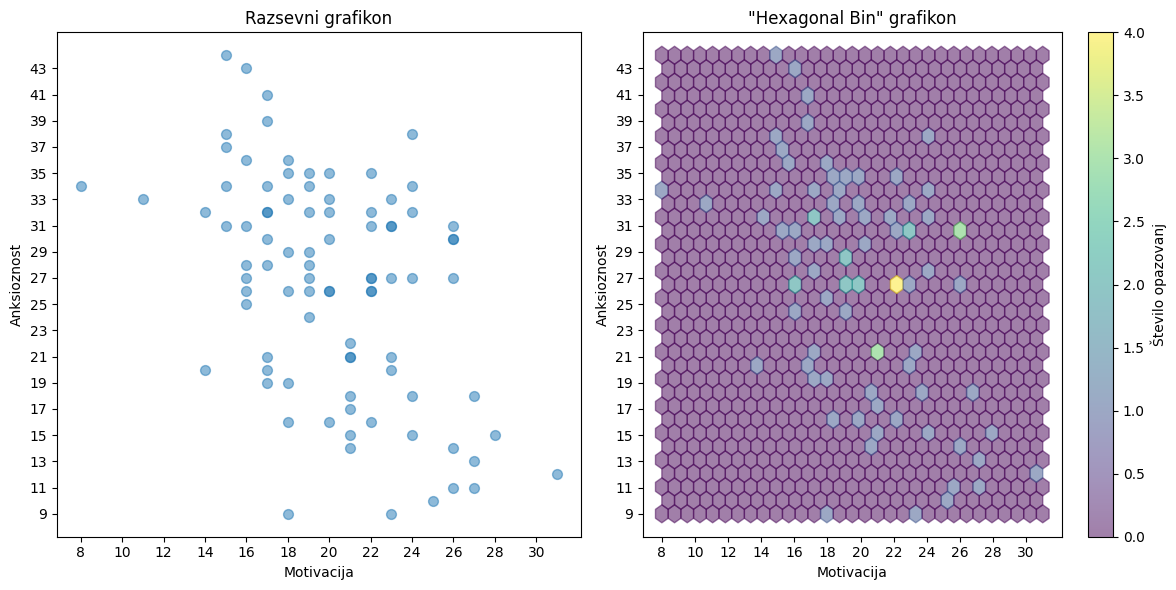

In [73]:
min_motivacija = df["Motivacija"].min()
max_motivacija = df["Motivacija"].max()
min_anksioznost = df["Anksioznost"].min()
max_anksioznost = df["Anksioznost"].max()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Najprej narišimo razsevni grafikon
axs[0].scatter(df["Motivacija"], df["Anksioznost"], alpha=0.5, s=50) #alpha nam pomaga razkriti, če imamo več vrednosti (transparentnost), s pa določa velikost
axs[0].set_xlabel('Motivacija')
axs[0].set_ylabel('Anksioznost')
axs[0].set_title('Razsevni grafikon')

# In še hexbin
hb = axs[1].hexbin(df["Motivacija"], df["Anksioznost"], gridsize=30, alpha=0.5)
axs[1].set_xlabel('Motivacija')
axs[1].set_ylabel('Anksioznost')
axs[1].set_title('"Hexagonal Bin" grafikon')

# Dodamo legendo za število vrednosti
plt.colorbar(hb, ax=axs[1], label='Število opazovanj')

# Želimo bolj gosto skalo spremenljivk (na dve vrednosti)
axs[0].set_xticks(np.arange(min_motivacija, max_motivacija + 1, 2))
axs[0].set_yticks(np.arange(min_anksioznost, max_anksioznost + 1, 2))
axs[1].set_xticks(np.arange(min_motivacija, max_motivacija + 1, 2))
axs[1].set_yticks(np.arange(min_anksioznost, max_anksioznost + 1, 2))

plt.tight_layout()
plt.show()

Glede na zgornja grafikona lahko postavimo hipotezo, da med matematično anksioznostjo in motivacijo za matematiko velja blaga negativna korelacija in blaga linearna zveza.

(Desni grafikon nima pretirane dodane vrednosti - le to, da imajo določene točke več vrednosti (največ pa 3))

## Interferenčna analiza

Raziskali bomo korelacijo med mat. anksioznostjo in motivacijo za matematiko. Nato bomo preverili še vpliv spola na matematično anksioznost.

Pred tem moramo ugotoviti predpostavke metod. Testirali bomo normalnost in linearnost.

Ničelna hipoteza za normalnost : $H_0^{\text{norm}}$: Porazdelitev je normalna (za obe spremenljivki posebej)

Ničelna hipoteza za linearnost: $H_0^{\text{lin}}$: Regresija med mat. anks. in motivac. je linenarna.

### Test normalnosti

Normalnost porazdelitve anksioznosti in motivacije bomo testirali s Shapiro-Wilkovim ($SW$) testom, saj je primeren za manjše vzorce. Predpostavi neodvisnost in naključnost enot
Poslužili se bomo še $QQ$ diagrama za primerjavo glede normalne porazdelitve in na podlagi opazk osnovali nadaljnje statistike.

Shapiro-Wilkov rezultat za Motivacija:
P-vrednost: 0.332
Hipoteze H0(norm) za Motivacija ne zavrnemo, saj je p > 0.05


Shapiro-Wilkov rezultat za Anksioznost:
P-vrednost: 0.018
Hipotezo H0(norm) za Anksioznost zavrnemo, saj je p < 0.05


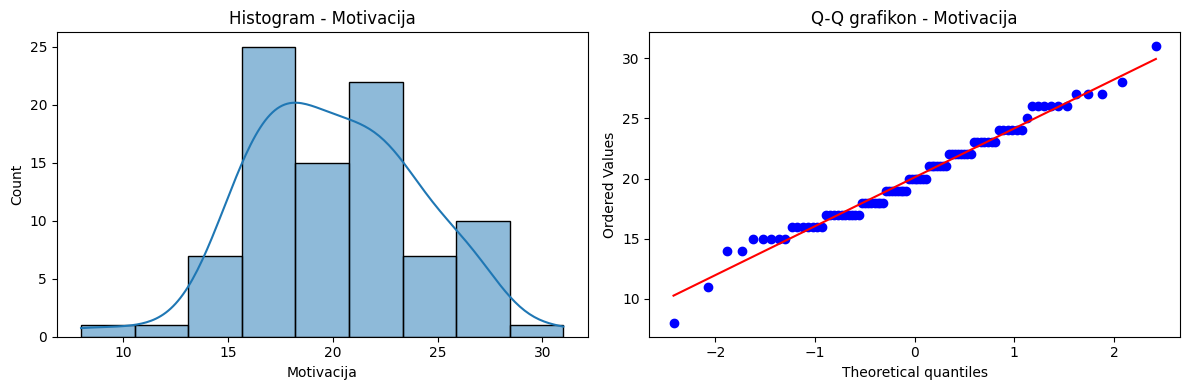

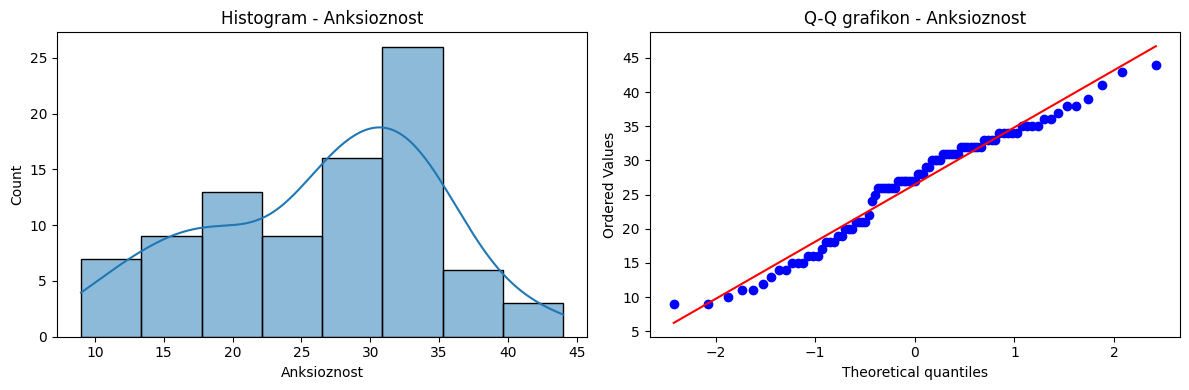

In [74]:
column1 = "Motivacija"  # Specificiramo spremenljivki, ki ju testiramo
column2 = "Anksioznost"

# Uporabimo testno funkcijo
statistic1, p_value1 = shapiro(df[column1])
statistic2, p_value2 = shapiro(df[column2])

# In jo prikažemo, skupaj s p-vrednostjo. Dodamo še opombo, ali je hipoteza o normalnosti zavrnjena, glede na p.
print(f"Shapiro-Wilkov rezultat za {column1}:")
print(f"P-vrednost: {p_value1:.3f}")
if p_value1 > 0.05:
    print(f"Hipoteze H0(norm) za {column1} ne zavrnemo, saj je p > 0.05")
else:
    print(f"Hipotezo H0(norm) za {column1} zavrnemo, saj je p < 0.05")

print("\n")

print(f"Shapiro-Wilkov rezultat za {column2}:")
print(f"P-vrednost: {p_value2:.3f}")
if p_value2 > 0.05:
    print(f"Hipoteze H0(norm) za {column2} ne zavrnemo, saj je p > 0.05")
else:
    print(f"Hipotezo H0(norm) za {column2} zavrnemo, saj je p < 0.05")

# Vizualni prikaz
plt.figure(figsize=(12, 4))

# Histogram za motivacijo
plt.subplot(1, 2, 1)
sns.histplot(df[column1], kde=True)
plt.title(f'Histogram - {column1}')

# Q-Q grafikon za motivacijo
plt.subplot(1, 2, 2)
probplot(df[column1], dist="norm", plot=plt)
plt.title(f'Q-Q grafikon - {column1}')

plt.tight_layout()
plt.show()

# Vizualni prikaz za anksioznost
plt.figure(figsize=(12, 4))

# Histogram za anksioznost
plt.subplot(1, 2, 1)
sns.histplot(df[column2], kde=True)
plt.title(f'Histogram - {column2}')

# Q-Q grafikon za anksioznost
plt.subplot(1, 2, 2)
probplot(df[column2], dist="norm", plot=plt)
plt.title(f'Q-Q grafikon - {column2}')

plt.tight_layout()
plt.show()

V $QQ$ grafikonu smo primerjali porazdelitve s teoretično normalno porazdelitvijo. Če bi bili porazdelitvi podobni, bi podatki sledili rdeči premici. 

In [75]:
# Skewness
skewness_motivacija = skew(df['Motivacija'])
skewness_anksioznost = skew(df['Anksioznost'])

# Kurtosis
kurtosis_motivacija = kurtosis(df['Motivacija'])
kurtosis_anksioznost = kurtosis(df['Anksioznost'])

print(f"Skewness za Motivacijo: {skewness_motivacija:.2f}")
print(f"Skewness za Anksioznost: {skewness_anksioznost:.2f}")
print(f"Kurtosis za Motivacijo: {kurtosis_motivacija:.2f}")
print(f"Kurtosis za Anksioznost: {kurtosis_anksioznost:.2f}")

Skewness za Motivacijo: 0.03
Skewness za Anksioznost: -0.33
Kurtosis za Motivacijo: 0.12
Kurtosis za Anksioznost: -0.68


Skewness motivacije je blizu 0, kar pomeni, da je porazdelitev skoraj simetrična okoli povprečja. Kurtosis je blizu 0, toda rahlo pozitiven, kar pomeni da sta repa malenkost težka in da je vrh bolj oster, toda minimalno.

Skewness anksioznosti je negativen, kar pomeni, da je težka v levo (spet ne ogromno). Kurtosis anksioznosti (negativen) pove, da je krivulja bolj sploščena.

Pokazali smo, da spremenljivka Anksioznost ni normalna, zato bomo v nadaljevanju uporabili neparametrične teste.

### Test linearnosti

Poslužili se bomo navadne linearne regresije med Motivacijo in Anksioznostjo

In [76]:
fit = smf.ols('Motivacija ~ Anksioznost', data=df).fit()        # Priložimo liearno regresijo

summary_output = fit.summary()
print(summary_output)                                           # In jo prikažemo

                            OLS Regression Results                            
Dep. Variable:             Motivacija   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     23.77
Date:                Sat, 04 May 2024   Prob (F-statistic):           4.85e-06
Time:                        17:07:24   Log-Likelihood:                -239.23
No. Observations:                  89   AIC:                             482.5
Df Residuals:                      87   BIC:                             487.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      26.0307      1.275     20.422      

Za odvisno spremenljivko smo si izbrali motivacijo, lahko pa bi brez zadržka spremenljivki tudi zamenjali (odvisno od tega, kaj bi želeli napovedati, kaj bi bili cilji raziskave ...).

Model pojasni $21.5%$ variance v motivaciji.

Visoka vrednost $F$-satistike in njena nizka pripadajoča $p$-vrednost (označena $Prob$) kaže, da je model statistično signifikanten.

Model kot tak ima koeficienta $\beta_0 = 26.0$ in $\beta_1 = -0.2$. Slednji nam ponovno sugerira hipotezo o negativni korelaciji. Pomenita, da bi oseba s teoretično 0 andksioznosti imela 26 motivacije in da se za vsako stopnjo anksioznosti motivacija zmanjša za 0.2.

Ker imata oba $\beta$ koeficienta nizko $p$-vrednost $t$-statistike $(P>|t|)$ sta oba koeficienta vplivna na izračun motivacije v regresiji.

Ostalih vrednosti ne bomo komentirali.

In [77]:
import statsmodels.formula.api as smf
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

names = ['Lagrange multiplier statistic', 'p-vrednost', 'f-vrednost', 'f p-vrednost']

# Dobimo statistike
test_result = sms.het_breuschpagan(fit.resid, fit.model.exog)

# In jih zaokrožimo
rounded_test_result = [(name, round(value, 2)) for name, value in zip(names, test_result)]

rounded_test_result


[('Lagrange multiplier statistic', 0.02),
 ('p-vrednost', 0.88),
 ('f-vrednost', 0.02),
 ('f p-vrednost', 0.88)]

Izvedli smo še Breusch Paganov test za predpostavko lienarnosti (bolj natančno heteroskedastičnost).

Velika $p$-vrednost obeh statistik nam ne sugestira, da bi bila heteroskedastičnost (ki pomeni, da bi bila varianca napake ne-konstantna - tega v lin. regresiji ne želimo!) prisotna, kar nam naprej omogoča uporabo linearne zveze.

Linearno regresijo lahko tudi grafično predstavimo.

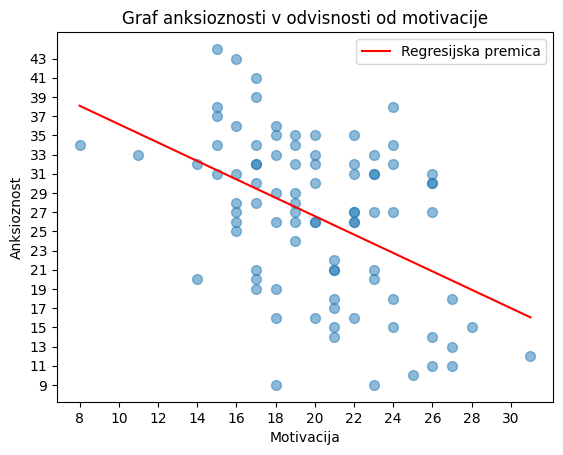

In [78]:
pyplot.scatter(df["Motivacija"], df["Anksioznost"], alpha=0.5, s=50)
pyplot.xlabel('Motivacija')
pyplot.ylabel('Anksioznost')
pyplot.title('Graf anksioznosti v odvisnosti od motivacije')

X = df[["Motivacija"]]
y = df["Anksioznost"]

model = LinearRegression().fit(X, y)
slope = model.coef_[0]
intercept = model.intercept_

# Točke, ki določajo regresijsko linijo
x_values = np.linspace(df["Motivacija"].min(), df["Motivacija"].max(), 100)
y_values = intercept + slope * x_values
pyplot.plot(x_values, y_values, color='red', label='Regresijska premica')

pyplot.xticks(np.arange(df["Motivacija"].min(), df["Motivacija"].max() + 1, 2))
pyplot.yticks(np.arange(df["Anksioznost"].min(), df["Anksioznost"].max() + 1, 2))

pyplot.legend()
pyplot.show()

## Korelacija

In [79]:
print(np.cov(df["Motivacija"], df["Anksioznost"])) #Kovariančna matrika

[[ 16.296476   -15.61759448]
 [-15.61759448  69.75255363]]


Diagonala predstavlja variance Motivacije in Anksioznosti, bolj pomembna pa je njuna kovarianca (-30.6). Ker je negativna nam sugerira inverzno zvezo med opazovanima spremenljivkama (ko se ena poveča, se druga zmanjša in obratno). Vrednost pa nam sugerira, da je relacija srednja (formalno tega sklepa sicer ne smemo narediti, saj kovarianca ni standardiziran test).

Za natančnejšo opredelitev bomo uporabili Spearmanov $\rho$ in Kendallov $\tau$ koeficient, saj gre za neparametrični metodi, ki ne privzameta linearne zveze in normalnosti. Oba delujeta na principu rangiranja podatkov. $\tau$ je občutljiv, če so nekatere vrednosti enake (v našem primeru smo npr. na heksagonalnem grafu opazili, da eno vrednost zajamejo tri opazovanja, toda ta primer je osamljen, zato sta obe metodi primerni).

Postavimo ničelno hipotezo $H_0^{\text{corr}}$: Med mat. anks. in motivacijo ni korelacije.

In [80]:
#pearson_corr, pearson_p_value = stats.pearsonr(df["Motivacija"], df["Anksioznost"])        #To ni ok, saj je Pearson parametričen test!
#print("Pearson correlation coefficient: %.3f" % pearson_corr)
#print("P-value: %.3f" % pearson_p_value)

spearman_corr, spearman_p_value = stats.spearmanr(df["Motivacija"], df["Anksioznost"])
print("Spearmanov koeficient rho: %.3f" % spearman_corr)                             #%.3f zapiše le prva tri mesta. Bolje bi bilo zaokroževati...
print("P-vrednost: %.3f" % spearman_p_value)

tau, p_value = stats.kendalltau(df["Motivacija"], df["Anksioznost"])
print("Kendallov tau: %.3f" % tau)
print("P-vrednost: %.3f"  % p_value)

Spearmanov koeficient rho: -0.432
P-vrednost: 0.000
Kendallov tau: -0.314
P-vrednost: 0.000


Oba koeficienta nam zavrneta ničelno hipotezo $H_0^{\text{corr}}$ ($p<0.05$). Na podlagi vrednosti koeficientov lahko sklepamo, da je korelacija srednja in negativna.

# Spol

Preučili bomo še ali ima spol vpliv na matematično anksioznost (za motivacijo bi pa zaradi normalnosti uporabili parametrične teste (npr. $t$)).

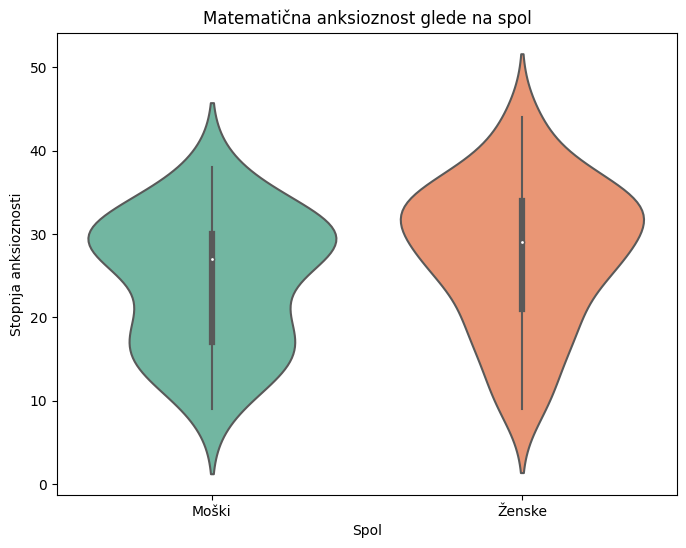

In [81]:
# Spet se poslužimo violinske škatle z brki.Prikažimo jo v malenkost bolj berljivi obliki, kjer min in max ne odrežemo, ampak zaradi estetskih razlogov bolj zvezno nadaljujemo.
# Vključimo pa notri (s sivo) še škatlo z brki.
plt.figure(figsize=(8, 6))
sns.violinplot(x='Spol', y='Anksioznost', data=df, palette='Set2')
plt.title('Matematična anksioznost glede na spol')
plt.xlabel('Spol')
plt.ylabel('Stopnja anksioznosti')
plt.xticks([0, 1], ['Moški', 'Ženske'])  # Dodamo legendo spola
plt.show()

Ker Anksioznost ni normalno porazdeljena, bomo uporabili neparametrični Mann-Whitney $U$ test (oz. Wilcoxonov test vsote rankov), ki je primeren za primerjavo spremenljivk zvezna-kategorična, kjer ima kategorična le dve stopnji (kot je pri nas spol).

Alternativi sta Mann-Whitney U test (oz. Wilcoxonov test vsote rankov) in Kruskal-Wallis-ov test. Oba sta neparametrična. Prvi je bolj primeren za primerjavo zvezna-kategorična, kjer ima kategorična le dve stopnji (kot pri nas spol), drugi pa sprejme tudi več kategorij.

In [82]:
mw_stat, p_value_mw = stats.mannwhitneyu(male_anxiety, female_anxiety)
print(f"Mann-Whitney U statistika: {mw_stat:.2f}\nP-vrednost: {p_value_mw:.2f}")

Mann-Whitney U statistika: 702.50
P-vrednost: 0.06


Na naših podatkih spol nima statističnega učinka na matematično anksioznost ($p>0.05$).

Prikažimo še Cohenov $d$ in $\eta^2$ za velikost vpliva kot komplementarno informacijo zgornjega testa (saj je $p$ zelo blizu kritični vrednosti).

In [83]:
mean_diff = male_anxiety.mean() - female_anxiety.mean()
pooled_std = ((len(male_anxiety) - 1) * male_anxiety.var() + (len(female_anxiety) - 1) * female_anxiety.var()) / (len(male_anxiety) + len(female_anxiety) - 2)
cohens_d = mean_diff / (pooled_std ** 0.5)
print(f"Cohen's d: {cohens_d:.3f}")

ss_between = ((male_anxiety.mean() - df['Anksioznost'].mean())**2 * len(male_anxiety) + (female_anxiety.mean() - df['Anksioznost'].mean())**2 * len(female_anxiety)) / (len(data) - 1)
ss_total = ((male_anxiety - df['Anksioznost'].mean())**2).sum() + ((female_anxiety - df['Anksioznost'].mean())**2).sum()
eta_squared = ss_between / ss_total
print(f"Eta-squared: {eta_squared:.3f}")

Cohen's d: -0.403
Eta-squared: 0.000


Negativni $d$ nam pove, da ima druga skupina (moški) nižjo Anksioznost kot prva (ženske). Absolutna vrednost tega nam sugerira blago do srednjo razliko med skupinama.

$\eta^2 = 0.00$ pove, da neodvisna spremenljivka (v našem primeru skupina, torej spol) ne pojasni nič variance v Anksioznosti. Z drugimi besedami, spol nima vpliva.

# Multivariatna statistika

Čeprav večina metod tukaj niti ni smiselnih, jih vseeno prikažimo :)

## MANOVA

Imamo dve odvisni spremenljivki (motivacija in anksioznost) in testiramo, ali se razlikujeta glede na stopnje kategorične neodvisne spremenljivke (spol, razred in profesor)

In [84]:
from statsmodels.multivariate.manova import MANOVA

X = df[['Motivacija', 'Anksioznost']]
y = df[['Razred', 'Profesor', 'Spol']]

manova = MANOVA.from_formula('X ~ Spol + Profesor + Razred', data=df)
print(manova.mv_test())

                  Multivariate linear model
                                                              
--------------------------------------------------------------
       Intercept         Value  Num DF  Den DF F Value  Pr > F
--------------------------------------------------------------
          Wilks' lambda  0.0809 2.0000 84.0000 477.0886 0.0000
         Pillai's trace  0.9191 2.0000 84.0000 477.0886 0.0000
 Hotelling-Lawley trace 11.3593 2.0000 84.0000 477.0886 0.0000
    Roy's greatest root 11.3593 2.0000 84.0000 477.0886 0.0000
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
            Spol          Value  Num DF  Den DF F Value Pr > F
--------------------------------------------------------------
            Wilks' lambda 0.9617 2.0000 84.0000  1.6746 0.1936
           Pillai's trace 0.0383 2.0000 84.0000  1.6746 0.1936
   Hotellin

### Interpretacija:

Splošen model: Vse mere (npr. Wilk $\lambda$ [gledamo $Pr > F$], ...) kažejo na statistično signifikanco.

Spol: Ni signifikance

Profesor: Ni signifikance

Razred: Ni signifikance

Rezultati so morda presenetljivi. Dobili smo, da je statistična signifikanca med skupinami, glede na kombinacijo vseh kategoričnih spremenljivk, ni pa razlik glede na posamezne spremenljivke.

To je možno - glej https://doi.org/10.1080/01621459.1972.10481293.... Glej še komentar spodaj, zakaj morda ta rezultat ni najboljši :)

## Multipla regresija

Denimo, da želimo napovedati razred (ki je kategorična). Seveda pričakujemo, da ima vpliv na to (pa še to ne popoln vpliv, saj lahko en profesor uči več razredov!) učeči profesor.

In [85]:
import statsmodels.api as sm

X = df[['Motivacija', 'Anksioznost', 'Spol', 'Profesor']]
X = sm.add_constant(X)  # Dodamo neko konstanto za $\beta_0$
y = df['Razred']

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 Razred   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     33.38
Date:                Sat, 04 May 2024   Prob (F-statistic):           1.18e-16
Time:                        17:07:25   Log-Likelihood:                -138.50
No. Observations:                  89   AIC:                             287.0
Df Residuals:                      84   BIC:                             299.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.2950      1.015     -0.291      

Seveda smo dobili, kar smo pričakovali. Tudi tukaj smo naredili statistični lapsus - glej spodaj.

#### Opomba glede lapsusa

Omenimo, da v zgornjih dveh testih statistika ni bila ravno korektna, saj bi bilo bolje za kategorije namesto "Label encodinga", uporabiti "One hot encoding". Prvega ("Label", ki smo ga mi uporabili) računalnik dejansko razuje naprej kot ordinalno spremenljivko in ne kategorično (če imamo več kot dve kategoriji). Dejansko bi morali uporabiti "OneHot", ki vsako kategorično spremenljivko loči na več stolpcev in da v vsakega vrednost 1, če mu pripada in vrednost 0, če mu ne. Glej primer zgoraj, kjer smo spol ločili na dva stolpca.

In [86]:
one_hot_encoded = pd.get_dummies(df['Spol'], prefix='Spol')

df_with_one_hot = pd.concat([df, one_hot_encoded], axis=1)
df_with_one_hot.drop('Spol', axis=1, inplace=True)

print(df_with_one_hot.head())

   Razred  Profesor  Motivacija  Anksioznost  Spol_0  Spol_1
0       5         1          22           16       1       0
1       5         1          19           26       0       1
2       3         1          21           17       1       0
3       5         1          19           35       0       1
4       3         1          19           34       0       1
